In [1]:
# Imports
import pprint
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns

# Function definitions
def classifier_performance_metrics(classifier, X_test, y_test):
    y_test_pred = classifier.predict(X_test)
    matrix = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp )
    recall = tp / (tp + fn)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall
    }

def path_to_vector(path):
    # multi hot bag of bytes encoding
    path_bytes = [i for i in bytes(path, 'ascii')]
    vector = [0 for i in range(0x20, 0x7e+1)]
    for i in path_bytes:
        try:
            vector[i - 0x20] = 1
        except Exception as e:
            print(i)
            raise e
    return vector

def render_printable(i):
    i = i + 0x20
    if i > 32 and i < 127:
        r = chr(i)
    else: 
        r = hex(i)
    return r

def get_coefs(classifier, layer_index, neuron_index):
    return [i[neuron_index] for i in classifier.coefs_[layer_index]]

def print_top_coefs(coefs, n=None):
    coefs = [(render_printable(i), v) for i,v in enumerate(coefs)]
    coefs = sorted(coefs, key = lambda i: -i[1])
    for i, v in enumerate(coefs[:n]):
        print(i+1, '\t', v[0], '\t', v[1])

def coefs_heatmap(coefs):
    reshaped_keys = [[None for i in range(int((len(coefs)/16)+1))] for i in range(16)]
    reshaped_values = [[None for i in range(int((len(coefs)/16)+1))] for j in range(16)]
    for index in range(0, len(coefs)):
        row = index % 16
        col = index // 16
        reshaped_keys[row][col] = render_printable(index)
        reshaped_values[row][col] = coefs[index]
    reshaped_keys = pd.DataFrame(reshaped_keys)
    reshaped_values = pd.DataFrame(reshaped_values)
    colors = ["#ffffff", "#024f6e"]
    sns.set_theme()
    my_cmap = sns.blend_palette(colors, as_cmap = True)
    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots(figsize=(6, 13.5))
    return sns.heatmap(
        reshaped_values, 
        annot=reshaped_keys, 
        fmt='', 
        linewidths=.5, 
        ax=ax, 
        cmap=my_cmap,
        xticklabels=[hex(i) for i in range(0x20,0x7e+1,16)],
        yticklabels=[hex(i) for i in range(0,16)]
    ).get_figure()

def coefs_swarmplot(coefs):
    character_classes = []
    for i, coefficient in enumerate(coefs):
        index = i + 0x20
        if index < ord('0'):
            character_classes.append(('Other', coefficient))
        elif index <= ord('9'):
            character_classes.append(('Digit', coefficient))
        elif index < ord('A'):
            character_classes.append(('Other', coefficient))
        elif index <= ord('Z'):
            character_classes.append(('Uppercase', coefficient))
        elif index < ord('a'):
            character_classes.append(('Other', coefficient))
        elif index <= ord('z'):
            character_classes.append(('Lowercase', coefficient))
        else:
            character_classes.append(('Other', coefficient))
    df_character_classes = pd.DataFrame(character_classes, columns = ["Class", "Coefficient"])
    colors = ["#ffffff", "#024f6e"][::-1]
    sns.set_theme(style='white')
    palette = sns.blend_palette(colors, n_colors=5)
    return sns.swarmplot(
        data=df_character_classes, 
        x="Coefficient", 
        y="Class", 
        palette=palette
    ).get_figure()

def create_ioc_classifier(ioc):
    class classifier(BaseEstimator, ClassifierMixin):
        def predict(self, X, y=None):
            index = ord(ioc) - 0x20
            return [x[index] for x in X]
    return classifier()

def evasion(classifier):
    attack = "/query/-4441' UNION ALL SELECT CHAR(113,112,122,113,113)||(SELECT (CASE WHEN (RANDOMBLOB(-1)>0) THEN 1 ELSE 0 END))||CHAR(113,122,122,106,113)-- "
    evasion = "abcdefghijklmnopqrstuvwxyz"
    result_baseline = classifier.predict([path_to_vector(attack)])
    result_evasion = classifier.predict([path_to_vector(attack + evasion)])
    return (result_baseline, result_evasion)


In [2]:
# Load & partition data
X = []
y = []

with open('data/paths-benign.txt', 'r') as f:
    for path in f.readlines():
        path = path.strip()
        X.append(path)
        y.append(0)

with open('data/paths-malicious.txt', 'r') as f:
    for path in f.readlines():
        path = path.strip()
        X.append(path)
        y.append(1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)

In [3]:
# Train neural network models
## Shallow
shallow_nn_classifier = MLPClassifier(hidden_layer_sizes=(), random_state=1234)
shallow_nn_classifier.fit([path_to_vector(x) for x in X_train], y_train)
## Deep
deep_nn_classifier = MLPClassifier(hidden_layer_sizes=(2,), random_state=1234)
deep_nn_classifier.fit([path_to_vector(x) for x in X_train], y_train)

MLPClassifier(hidden_layer_sizes=(2,), random_state=1234)

In [4]:
# Neural network inspection
## Shallow
coefs = get_coefs(shallow_nn_classifier,0,0)
print_top_coefs(coefs, n=5)


1 	 ' 	 1.2652229150034104
2 	 ( 	 1.0984161345111552
3 	 ) 	 1.0573588816007604
4 	 0x20 	 1.0545668961701062
5 	 = 	 1.022829576638783


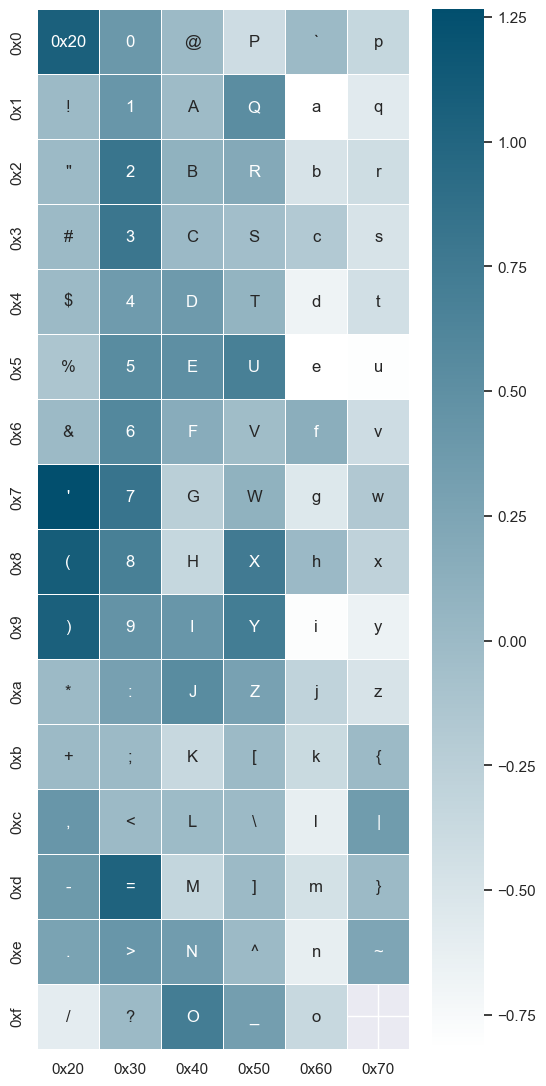

In [5]:
heatmap = coefs_heatmap(coefs)
heatmap.savefig('images/classifier-coefficients.png')

/var/folders/7_/vqvgb2m55hz12zhsbwdzg5q80000gn/T/ipykernel_89846/2565709633.py:103: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  return sns.swarmplot(
/var/folders/7_/vqvgb2m55hz12zhsbwdzg5q80000gn/T/ipykernel_89846/2565709633.py:103: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  return sns.swarmplot(
/Users/justin/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3544: UserWarning: 15.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/justin/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3544: UserWarning: 21.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


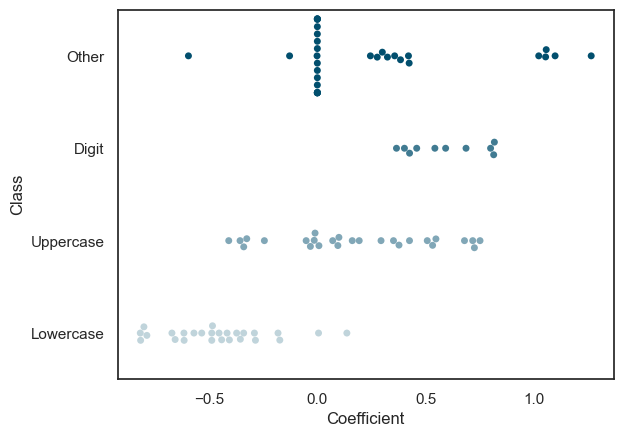

In [6]:
swarmplot = coefs_swarmplot(coefs)
swarmplot.savefig('images/character-class-coefficients.png', dpi=1024, bbox_inches="tight")

In [7]:
## Deep Neural Network
pprint.pprint(numpy.array(deep_nn_classifier.coefs_[1]).shape)
pprint.pprint(deep_nn_classifier.coefs_[1])

(2, 1)
array([[-1.43535519],
       [ 1.1057693 ]])


In [8]:
## DNN Node A: Counter-indicative (-1.453)
dnn_a_coefs = get_coefs(deep_nn_classifier,0,0)
print_top_coefs(dnn_a_coefs, n=5)


1 	 r 	 0.5726680102835658
2 	 q 	 0.5520903871787386
3 	 g 	 0.5279478609882114
4 	 d 	 0.5127385505562277
5 	 / 	 0.5107739327301383


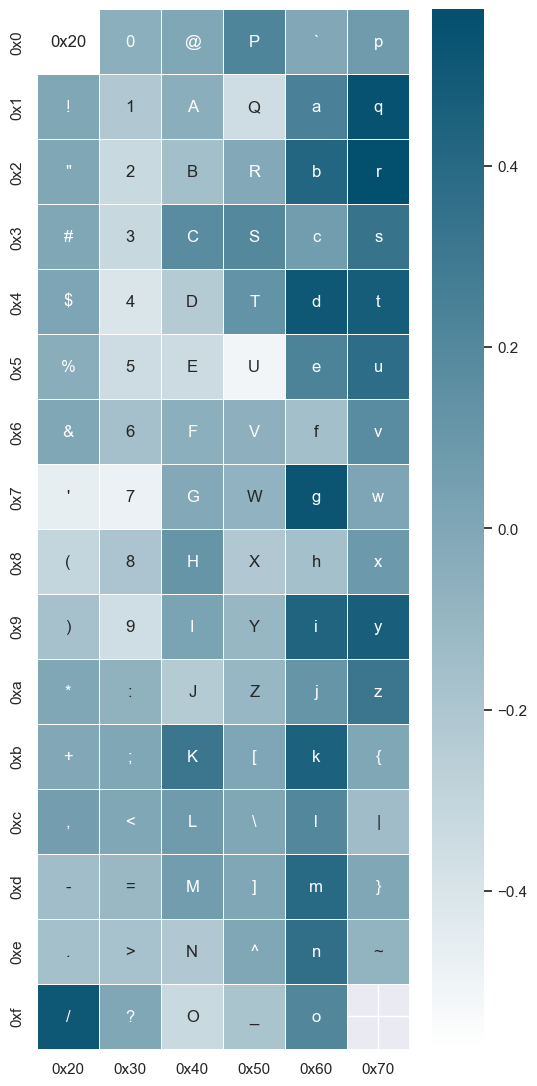

In [9]:
fig = coefs_heatmap(dnn_a_coefs)
fig.savefig('images/deep-classifier-coefficients-NodeA.png')

/var/folders/7_/vqvgb2m55hz12zhsbwdzg5q80000gn/T/ipykernel_89846/2565709633.py:103: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  return sns.swarmplot(
/var/folders/7_/vqvgb2m55hz12zhsbwdzg5q80000gn/T/ipykernel_89846/2565709633.py:103: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  return sns.swarmplot(
/Users/justin/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3544: UserWarning: 12.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/justin/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3544: UserWarning: 18.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


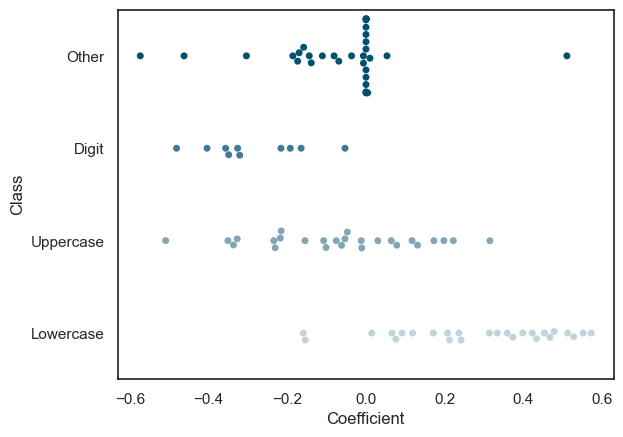

In [10]:
fig = coefs_swarmplot(dnn_a_coefs)
fig.savefig('images/DNN-NodeA-swarmplot.png')

In [11]:
## DNN Node B: Indicative (1.11)
dnn_b_coefs = get_coefs(deep_nn_classifier,0,1)
print_top_coefs(dnn_b_coefs, n=5)


1 	 N 	 0.5423210022702019
2 	 3 	 0.5347498437760254
3 	 E 	 0.5256455139079598
4 	 ) 	 0.5187260736301402
5 	 0x20 	 0.5144484422397182


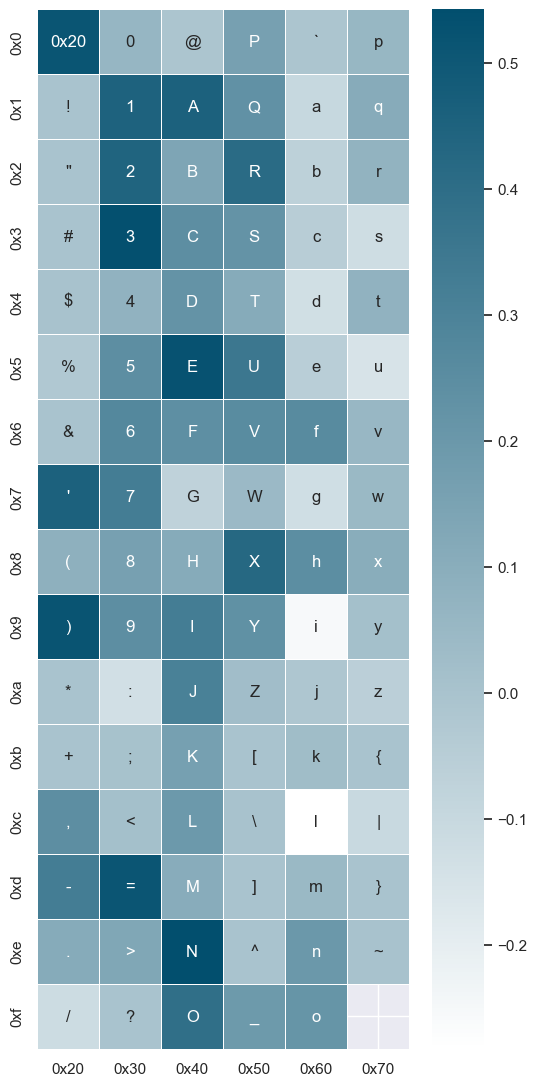

In [12]:
fig = coefs_heatmap(dnn_b_coefs)
fig.savefig('images/deep-classifier-coefficients-NodeB.png')

/var/folders/7_/vqvgb2m55hz12zhsbwdzg5q80000gn/T/ipykernel_89846/2565709633.py:103: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  return sns.swarmplot(
/var/folders/7_/vqvgb2m55hz12zhsbwdzg5q80000gn/T/ipykernel_89846/2565709633.py:103: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  return sns.swarmplot(
/Users/justin/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3544: UserWarning: 12.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/justin/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3544: UserWarning: 18.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


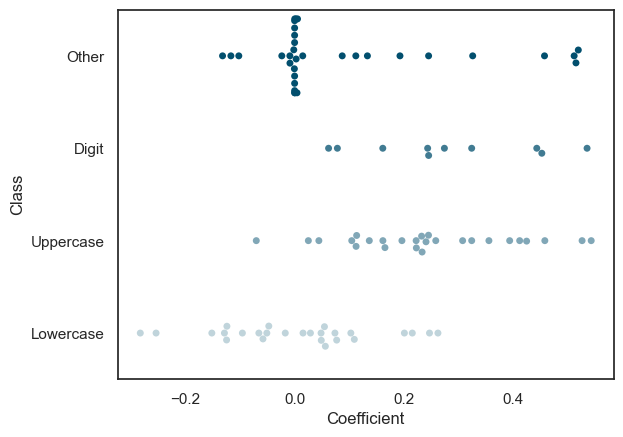

In [13]:
fig = coefs_swarmplot(dnn_b_coefs)
fig.savefig('images/DNN-NodeB-swarmplot.png')


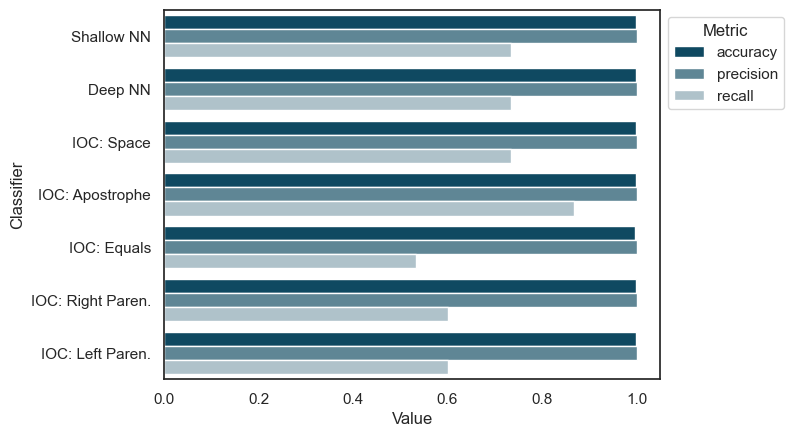

In [16]:
classifiers = {
    'Shallow NN': shallow_nn_classifier,
    'Deep NN': deep_nn_classifier,
    'IOC: Space': create_ioc_classifier(' '),
    'IOC: Apostrophe': create_ioc_classifier("'"),
    'IOC: Equals': create_ioc_classifier('='),
    'IOC: Right Paren.': create_ioc_classifier(")"),
    'IOC: Left Paren.': create_ioc_classifier("(")
}
X_test_vectorized = [path_to_vector(x) for x in X_test]
colors = ["#ffffff", "#024f6e"][::-1]
sns.set_theme(style='white')
palette = sns.blend_palette(colors, n_colors=4)
rows = []
for classifier_name, classifier in classifiers.items():
    performance = classifier_performance_metrics(classifier, X_test_vectorized, y_test)
    for metric, value in performance.items():
        rows.append([classifier_name, metric, value])
df = pd.DataFrame(rows, columns=["Classifier", "Metric", "Value"])
df.head()
ax = sns.barplot(
    x="Value", 
    y="Classifier",
    hue='Metric',
    data=df,
    palette=palette
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.get_figure().savefig('images/classifier-performance.png', dpi=1024, bbox_inches="tight")


In [35]:

print('{a:20} {b:20} {c:20}'.format(a="Classifier Name", b="Result: Attack", c="Result: Evasion"))
print('-'*60)
for classifier_name, classifier in classifiers.items():
    result_basic, result_evasion = evasion(classifier)
    print(f'{classifier_name:20} {result_basic[0]:<20} {result_evasion[0]:<20}')

Classifier Name      Result: Attack       Result: Evasion     
------------------------------------------------------------
Shallow NN           1                    0                   
Deep NN              1                    1                   
IOC: Space           1                    1                   
IOC: Apostrophe      1                    1                   
IOC: Equals          0                    0                   
IOC: Right Paren.    1                    1                   
IOC: Left Paren.     1                    1                   
